In [1]:
import pandas as pd
import glob
import multiprocessing as mp
import bilby
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Define new frequency domain source model 
bilby.core.utils.setup_logger(log_level='ERROR')
# Here we define out source model - this is the sine-Gaussian model in the
# frequency domain.
def lorentzian(frequency_array, amplitude, f0, gamma,inclination_angle):
    r"""
    Our custom source model which approximates a PMR peak frequency.
    This is just a lorentzian in frequency domain with a peak frequency f0 and a damping time quantity gamma.


    Parameters
    ----------
    frequency_array: array-like
        The frequencies to evaluate the model at. This is required for all
        Bilby source models.
    amplitude: float
        An overall amplitude prefactor.
    f0: float
        The central frequency.
    tau: float
        The damping rate.

    Returns
    -------
    dict:
        A dictionary containing "plus" and "cross" entries.

    """
    # Evaluate the lorentzian
    # Which version do we want to use? 
    arg2 = (amplitude**2.)/((frequency_array-f0)**2. + gamma**2.)
    arg = np.sqrt(arg2)
    # Take the real and complex parts for the plus and cross respectively 
    plus = 0.5*(1. + np.cos(inclination_angle)**2.)*arg2
    cross = - 1j*(np.cos(inclination_angle))*arg2
    return {"plus": plus, "cross": cross}



In [4]:
# Damped sinousid time domain
def time_domain_damped_sinusoid(time, amplitude, damping_time, frequency, phase, t0):
    r"""
    This example only creates a linearly polarised signal with only plus
    polarisation.

    .. math::

        h_{\plus}(t) =
            \Theta(t - t_{0}) A
            e^{-(t - t_{0}) / \tau}
            \sin \left( 2 \pi f t + \phi \right)

    Parameters
    ----------
    time: array-like
        The times at which to evaluate the model. This is required for all
        time-domain models.
    amplitude: float
        The peak amplitude.
    damping_time: float
        The damping time of the exponential.
    frequency: float
        The frequency of the oscillations.
    phase: float
        The initial phase of the signal.
    t0: float
        The offset of the start of the signal from the start time.

    Returns
    -------
    dict:
        A dictionary containing "plus" and "cross" entries.

    """
    plus = np.zeros(len(time))
    tidx = time >= t0
    plus[tidx] = (amplitude* np.exp(-(time[tidx] - t0) / damping_time)* np.sin(2 * np.pi * frequency * (time[tidx] - t0) + phase))
    cross = (amplitude* np.exp(-(time[tidx] - t0) / damping_time)* np.sin(2 * np.pi * frequency * (time[tidx] - t0) + phase+ np.pi/2))
    #print(plus)
    return {"plus": plus, "cross": cross}


# define parameters to inject.
injection_parameters = dict(
    amplitude=1e-22,
    damping_time=0.1,
    frequency=700,
    phase=0,
    ra=0,
    dec=0,
    psi=0,
    t0=0.0,
    geocent_time=0.0,
)



In [5]:
sampling_frequency = 16384 #4096
duration = 1



# # We now define some parameters that we will inject
# injection_parameters = dict(
#     amplitude=1e-2, f0=300, tau=1, phi0=0, geocent_time=0, ra=0, dec=0, psi=0,inclination_angle=0,gamma=100
# )


# Now we pass our source function to the WaveformGenerator
waveform_generator = bilby.gw.waveform_generator.WaveformGenerator(
    duration=duration,
    sampling_frequency=sampling_frequency,
    time_domain_source_model=time_domain_damped_sinusoid,
    #frequency_domain_source_model=lorentzian,
)

# Set up interferometers.
ifos = bilby.gw.detector.InterferometerList(["CE", "CE"])
ifos.set_strain_data_from_power_spectral_densities(
    sampling_frequency=sampling_frequency,
    duration=duration,
    start_time=injection_parameters["geocent_time"] - 0.5,
)
ifos.inject_signal(
    waveform_generator=waveform_generator,
    parameters=injection_parameters,
    raise_error=False,
)



[{'plus': array([ 2.25985736e-26+0.00000000e+00j,  2.25986200e-26-1.47687674e-31j,
          2.25987592e-26-2.95378966e-31j, ...,
         -4.12076106e-28-9.82119549e-35j, -4.12076060e-28-4.91058929e-35j,
         -4.12076044e-28+0.00000000e+00j]),
  'cross': array([3.10362268e-27+0.00000000e+00j, 3.10362300e-27+3.26744403e-29j,
         3.10362394e-27+6.53492783e-29j, ...,
         3.05256752e-27-1.19162078e-30j, 3.05256752e-27-5.95810368e-31j,
         3.05256752e-27+0.00000000e+00j])},
 {'plus': array([ 2.25985736e-26+0.00000000e+00j,  2.25986200e-26-1.47687674e-31j,
          2.25987592e-26-2.95378966e-31j, ...,
         -4.12076106e-28-9.82119549e-35j, -4.12076060e-28-4.91058929e-35j,
         -4.12076044e-28+0.00000000e+00j]),
  'cross': array([3.10362268e-27+0.00000000e+00j, 3.10362300e-27+3.26744403e-29j,
         3.10362394e-27+6.53492783e-29j, ...,
         3.05256752e-27-1.19162078e-30j, 3.05256752e-27-5.95810368e-31j,
         3.05256752e-27+0.00000000e+00j])}]

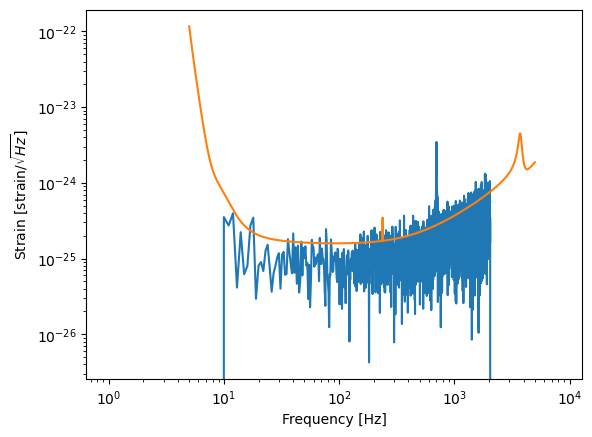

In [23]:
fig, ax = plt.subplots()
H1 = ifos[0]

#idxs = H1.strain_data.frequency_mask  # This is a boolean mask of the frequencies which we'll use in the analysis
ax.loglog(H1.strain_data.frequency_array,
          np.abs(H1.strain_data.frequency_domain_strain))
ax.loglog(H1.power_spectral_density.frequency_array,
          H1.power_spectral_density.asd_array)
ax.set_xlabel("Frequency [Hz]")
ax.set_ylabel("Strain [strain/$\sqrt{Hz}$]")
#plt.xlim(650,1000)
plt.show()

[0.00000000e+00 5.01002004e-05 1.00200401e-04 1.50300601e-04
 2.00400802e-04 2.50501002e-04 3.00601202e-04 3.50701403e-04
 4.00801603e-04 4.50901804e-04 5.01002004e-04 5.51102204e-04
 6.01202405e-04 6.51302605e-04 7.01402806e-04 7.51503006e-04
 8.01603206e-04 8.51703407e-04 9.01803607e-04 9.51903808e-04
 1.00200401e-03 1.05210421e-03 1.10220441e-03 1.15230461e-03
 1.20240481e-03 1.25250501e-03 1.30260521e-03 1.35270541e-03
 1.40280561e-03 1.45290581e-03 1.50300601e-03 1.55310621e-03
 1.60320641e-03 1.65330661e-03 1.70340681e-03 1.75350701e-03
 1.80360721e-03 1.85370741e-03 1.90380762e-03 1.95390782e-03
 2.00400802e-03 2.05410822e-03 2.10420842e-03 2.15430862e-03
 2.20440882e-03 2.25450902e-03 2.30460922e-03 2.35470942e-03
 2.40480962e-03 2.45490982e-03 2.50501002e-03 2.55511022e-03
 2.60521042e-03 2.65531062e-03 2.70541082e-03 2.75551102e-03
 2.80561122e-03 2.85571142e-03 2.90581162e-03 2.95591182e-03
 3.00601202e-03 3.05611222e-03 3.10621242e-03 3.15631263e-03
 3.20641283e-03 3.256513

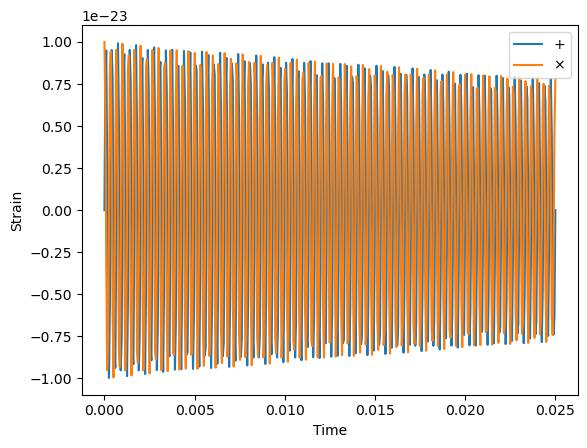

In [77]:
# Just generate and plot a raw lorentzian
amplitude=1e-23
# Still need to know what this value is!!!
damping_time=0.1
frequency=3000
phase=0
ra=0
dec=0
psi=0
t0=0.0
geocent_time=0.0
times = np.linspace(0,0.025,500)
print(times)
h = time_domain_damped_sinusoid(times, amplitude, damping_time, frequency, phase, t0)
print(h)
plt.plot(times,h["plus"],label=r'$+$')
plt.plot(times,h['cross'],label=r'$\times$')
plt.xlabel("Time")
plt.legend()
plt.ylabel("Strain")
plt.savefig("damped_sine.png",dpi=500)

In [8]:
# Read in the peak frequencies 
import pandas as pd
import glob
import multiprocessing as mp

def read_mass_freq_file(filepath):
    df = pd.read_csv(filepath, delim_whitespace=True, header=None, names=["mass_solar","radius km", "freq_khz"])
    df["source_file"] = filepath  # Add filename as identifier (optional)
    return df

# Collect all filenames
file_list_hot= glob.glob("/Users/smag0001/Downloads/f_peak_S_2_new/*.out")  # or adjust as needed
file_list = glob.glob("/Users/smag0001/Downloads/f_peak_T_0_new/*.out")
#print(file_list)

dfs = [read_mass_freq_file(f) for f in file_list]
dfs_hot = [read_mass_freq_file(f) for f in file_list_hot]
all_data = pd.concat(dfs, ignore_index=True)
all_data_hot = pd.concat(dfs_hot,ignore_index=True)
print(all_data)

       mass_solar  radius km  freq_khz  \
0        2.200000  16.716112  3.318129   
1        2.210000  16.702856  3.328729   
2        2.220000  16.689314  3.339416   
3        2.230000  16.675623  3.350153   
4        2.240000  16.661696  3.360966   
...           ...        ...       ...   
97952    2.900000  15.670855  4.128786   
97953    2.910000  15.598207  4.162577   
97954    2.920000  15.509372  4.202935   
97955    2.930000  15.387869  4.256584   
97956    2.939383  15.087150  4.383327   

                                             source_file  
0      /Users/smag0001/Downloads/f_peak_T_0_new/f_pea...  
1      /Users/smag0001/Downloads/f_peak_T_0_new/f_pea...  
2      /Users/smag0001/Downloads/f_peak_T_0_new/f_pea...  
3      /Users/smag0001/Downloads/f_peak_T_0_new/f_pea...  
4      /Users/smag0001/Downloads/f_peak_T_0_new/f_pea...  
...                                                  ...  
97952  /Users/smag0001/Downloads/f_peak_T_0_new/f_pea...  
97953  /Users/smag0001/

In [120]:
# Randomly draw 100 PMR from the dataset and calculate peak frequency
# This probably 
n_PMR = 1000
PMR_samples = all_data_hot.sample(n=n_PMR) 
print(PMR_samples)

       mass_solar  radius km  freq_khz  \
57787        2.91  18.674177  3.238675   
28232        2.69  18.229132  3.229374   
83849        2.68  17.605403  3.382860   
89923        2.42  20.389690  2.640387   
95241        2.99  18.611266  3.294706   
...           ...        ...       ...   
49642        2.92  19.029966  3.160443   
56367        2.78  19.691011  2.948584   
40432        2.40  20.308427  2.644777   
87230        2.55  19.115363  2.952154   
52406        2.74  19.030121  3.069518   

                                             source_file  
57787  /Users/smag0001/Downloads/f_peak_S_2_new/f_pea...  
28232  /Users/smag0001/Downloads/f_peak_S_2_new/f_pea...  
83849  /Users/smag0001/Downloads/f_peak_S_2_new/f_pea...  
89923  /Users/smag0001/Downloads/f_peak_S_2_new/f_pea...  
95241  /Users/smag0001/Downloads/f_peak_S_2_new/f_pea...  
...                                                  ...  
49642  /Users/smag0001/Downloads/f_peak_S_2_new/f_pea...  
56367  /Users/smag0001/

In [ ]:
def inject_PMR_signal(f_peak,network_conf):

    print(f_peak)
    
    sampling_frequency = 16384 #4096
    duration = 20



    # # We now define some parameters that we will inject
    
    
    injection_parameters = dict(
        amplitude=1e-23,
        damping_time=3,
        frequency=f_peak,
        phase=0,
        ra=0,
        dec=0,
        psi=0,
        t0=0.0,
        geocent_time=0.0,
    )



    # Now we pass our source function to the WaveformGenerator
    waveform_generator = bilby.gw.waveform_generator.WaveformGenerator(
        duration=duration,
        sampling_frequency=sampling_frequency,
        time_domain_source_model=time_domain_damped_sinusoid,
    )

    # Set up interferometers.
    ifos = bilby.gw.detector.InterferometerList([network_conf[0], network_conf[1]])
    ifos.set_strain_data_from_power_spectral_densities(
    sampling_frequency=sampling_frequency,
    duration=duration,
    start_time=injection_parameters["geocent_time"] - 0.5,
    )
    ifos.inject_signal(
        waveform_generator=waveform_generator,
        parameters=injection_parameters,
        raise_error=False,
    )

    network_snr_sqr = 0.0 
    # Extract SNR 
    for ifo in ifos:
        if hasattr(ifo, 'meta_data') and 'optimal_SNR' in ifo.meta_data:
            optimal_snr = ifo.meta_data['optimal_SNR']
            network_snr_sqr += optimal_snr**2.
    network_snr = np.sqrt(network_snr_sqr)
    
    return network_snr 

print(inject_PMR_signal(1500,["CE","CE"]))

In [ ]:
def get_SNRs_from_network_conf(PMR_samples,network_conf):

    print(PMR_samples)
    SNRs = inject_PMR_signal(PMR_samples['freq_khz'],network_conf)
    


    return SNRs

get_SNRs_from_network_conf(PMR_samples,["CE","CE"])

In [82]:
import numpy as np
import pandas as pd
import bilby
from concurrent.futures import ThreadPoolExecutor
import multiprocessing as mp

def inject_PMR_signal_vectorized(f_peaks, network_conf, n_jobs=None):
    """
    Vectorized version to inject PMR signals for multiple frequencies
    
    Parameters:
    -----------
    f_peaks : array-like
        Array of frequencies in Hz
    network_conf : list
        Network configuration for interferometers
    n_jobs : int, optional
        Number of parallel jobs. If None, uses all available CPUs
    
    Returns:
    --------
    numpy.array : Array of network SNRs
    """
    f_peaks = np.array(f_peaks)
    
    # Set up parameters that don't change
    sampling_frequency = 16384
    duration = 1.0
    # Ra and dec - sky position is changed randomly
    np.random.seed(42) # This is a HACK FIX!!! we want the binaries to all be the same so we set a seed. 
    ra = np.random.uniform(0, 2 * np.pi)  # Right ascension: 0 to 2π
    dec = np.random.uniform(-np.pi/2, np.pi/2)  # Declination: -π/2 to π/2
    # Base injection parameters
    base_injection_parameters = dict(
        amplitude=5e-22,
        damping_time=0.2,
        phase=0,
        ra=ra,
        dec=dec,
        psi=0,
        t0=0.0,
        geocent_time=0.0,
    )
    
    # Set up waveform generator (assuming you have time_domain_damped_sinusoid defined)
    waveform_generator = bilby.gw.waveform_generator.WaveformGenerator(
        duration=duration,
        sampling_frequency=sampling_frequency,
        time_domain_source_model=time_domain_damped_sinusoid,
    )
    
    def calculate_snr_batch(f_peaks_batch):
        """Calculate SNR for a batch of frequencies"""
        network_snrs = []
        
        for f_peak in f_peaks_batch:
            # Update injection parameters
            injection_parameters = base_injection_parameters.copy()
            injection_parameters['frequency'] = f_peak
            
            # Set up interferometers
            ifos = bilby.gw.detector.InterferometerList([network_conf[0], network_conf[1]])
            ifos.set_strain_data_from_power_spectral_densities(
                sampling_frequency=sampling_frequency,
                duration=duration,
                start_time=injection_parameters["geocent_time"] - 0.5,
            )
            
            # Inject signal
            ifos.inject_signal(
                waveform_generator=waveform_generator,
                parameters=injection_parameters,
                raise_error=False,
            )
            
            # Calculate network SNR
            network_snr_sqr = 0.0
            for ifo in ifos:
                if hasattr(ifo, 'meta_data') and 'optimal_SNR' in ifo.meta_data:
                    optimal_snr = ifo.meta_data['optimal_SNR']
                    network_snr_sqr += optimal_snr**2.0
            
            network_snr = np.sqrt(network_snr_sqr)
            network_snrs.append(network_snr)
        
        return network_snrs
    
    # Single-threaded for small datasets, parallel for large ones
    if len(f_peaks) < 100:
        network_snrs = calculate_snr_batch(f_peaks)
    else:
        # Parallel processing for large datasets
        if n_jobs is None:
            n_jobs = mp.cpu_count()
        
        # Split f_peaks into chunks
        chunk_size = max(1, len(f_peaks) // n_jobs)
        f_peaks_chunks = [f_peaks[i:i + chunk_size] for i in range(0, len(f_peaks), chunk_size)]
        
        # Process chunks in parallel
        with ThreadPoolExecutor(max_workers=n_jobs) as executor:
            chunk_results = list(executor.map(calculate_snr_batch, f_peaks_chunks))
        
        # Flatten results
        network_snrs = [snr for chunk_result in chunk_results for snr in chunk_result]
    
    return np.array(network_snrs)

def get_SNRs_from_network_conf(PMR_samples, network_conf):
    """
    Get SNRs from network configuration using vectorized injection
    
    Parameters:
    -----------
    PMR_samples : pandas.DataFrame
        DataFrame containing 'freq_khz' column with frequencies
    network_conf : list
        Network configuration for interferometers
    
    Returns:
    --------
    numpy.array : Array of network SNRs
    """
    print(PMR_samples)
    
    # Convert freq_khz to Hz
    freq_hz = PMR_samples['freq_khz'] * 1000
    
    # Get SNRs using vectorized function
    SNRs = inject_PMR_signal_vectorized(freq_hz, network_conf)
    
    return SNRs

In [83]:
SNRs = get_SNRs_from_network_conf(PMR_samples,["NEMO","CE"])
SNRs_CE_het = get_SNRs_from_network_conf(PMR_samples,["CE","CE"])

       mass_solar  radius km  freq_khz  \
36503        2.48  16.792068  3.485029   
72194        2.88  17.403363  3.553949   
6213         2.53  15.166029  4.055441   
95553        2.42  16.519987  3.524832   
30919        2.77  16.974715  3.613604   
...           ...        ...       ...   
46401        2.58  15.823153  3.856382   
38981        2.82  15.781214  4.035047   
71084        2.22  15.354164  3.749992   
96759        2.54  16.361817  3.653507   
93181        2.45  17.130714  3.370804   

                                             source_file  
36503  /Users/smag0001/Downloads/f_peak_T_0_new/f_pea...  
72194  /Users/smag0001/Downloads/f_peak_T_0_new/f_pea...  
6213   /Users/smag0001/Downloads/f_peak_T_0_new/f_pea...  
95553  /Users/smag0001/Downloads/f_peak_T_0_new/f_pea...  
30919  /Users/smag0001/Downloads/f_peak_T_0_new/f_pea...  
...                                                  ...  
46401  /Users/smag0001/Downloads/f_peak_T_0_new/f_pea...  
38981  /Users/smag0001/

In [65]:
SNRs_CE_ET = get_SNRs_from_network_conf(PMR_samples,["CE","ET"])
SNRs_CE_ET_NEMO = get_SNRs_from_network_conf(PMR_samples,["CE","ET","NEMO"])
SNRs_CE_ET_NEMO_A1 = get_SNRs_from_network_conf(PMR_samples,["CE","ET","NEMO","A1"])

       mass_solar  radius km  freq_khz  \
36503        2.48  16.792068  3.485029   
72194        2.88  17.403363  3.553949   
6213         2.53  15.166029  4.055441   
95553        2.42  16.519987  3.524832   
30919        2.77  16.974715  3.613604   
...           ...        ...       ...   
46401        2.58  15.823153  3.856382   
38981        2.82  15.781214  4.035047   
71084        2.22  15.354164  3.749992   
96759        2.54  16.361817  3.653507   
93181        2.45  17.130714  3.370804   

                                             source_file  
36503  /Users/smag0001/Downloads/f_peak_T_0_new/f_pea...  
72194  /Users/smag0001/Downloads/f_peak_T_0_new/f_pea...  
6213   /Users/smag0001/Downloads/f_peak_T_0_new/f_pea...  
95553  /Users/smag0001/Downloads/f_peak_T_0_new/f_pea...  
30919  /Users/smag0001/Downloads/f_peak_T_0_new/f_pea...  
...                                                  ...  
46401  /Users/smag0001/Downloads/f_peak_T_0_new/f_pea...  
38981  /Users/smag0001/

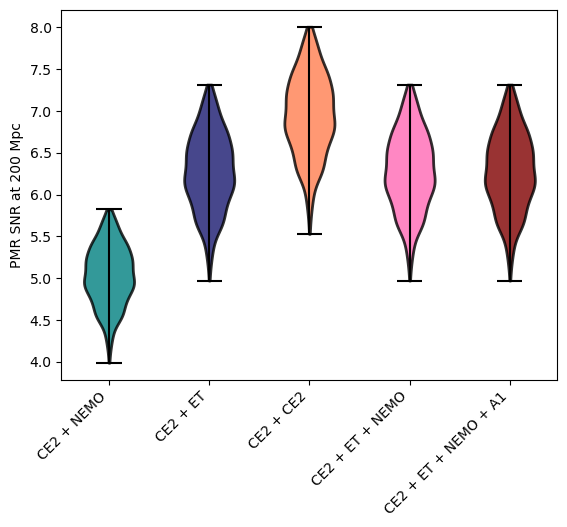

In [73]:
colors = ['teal','midnightblue','coral','hotpink','maroon']
edge_color= 'black'
parts = plt.violinplot([SNRs,SNRs_CE_ET,SNRs_CE_het,SNRs_CE_ET_NEMO,SNRs_CE_ET_NEMO_A1])
for pc, color in zip(parts['bodies'], colors):
    pc.set_facecolor(color)
    pc.set_edgecolor(edge_color)  # Match the error bar color
    pc.set_linewidth(2)
    pc.set_alpha(0.8)

# Set error bars to match edge color
parts['cmins'].set_color(edge_color)
parts['cmaxes'].set_color(edge_color)
parts['cbars'].set_color(edge_color)
#parts['cmedians'].set_color(edge_color)
# Long labels
labels = ['CE2 + NEMO', 'CE2 + ET', 'CE2 + CE2', 'CE2 + ET + NEMO','CE2 + ET + NEMO + A1']
plt.xticks(range(1, len(labels) + 1), labels, rotation=45, ha='right')
plt.ylabel('PMR SNR at 200 Mpc')
#plt.savefig('SNR_violinplot.pdf',bbox_inches='tight')
plt.savefig('SNR_violinplot.png',dpi=500,bbox_inches='tight')

In [123]:
# The same thing but for cold EOSs
# Randomly draw 100 PMR from the dataset and calculate peak frequency
# This probably 
n_PMR = 10000
PMR_samples = all_data.sample(n=n_PMR) 
print(PMR_samples)

       mass_solar  radius km  freq_khz  \
36503        2.48  16.792068  3.485029   
72194        2.88  17.403363  3.553949   
6213         2.53  15.166029  4.055441   
95553        2.42  16.519987  3.524832   
30919        2.77  16.974715  3.613604   
...           ...        ...       ...   
29981        2.74  16.895053  3.619016   
40952        2.54  17.450553  3.340724   
10538        2.33  15.793774  3.687134   
54206        2.70  15.769869  3.957794   
27592        2.47  17.435273  3.301942   

                                             source_file  
36503  /Users/smag0001/Downloads/f_peak_T_0_new/f_pea...  
72194  /Users/smag0001/Downloads/f_peak_T_0_new/f_pea...  
6213   /Users/smag0001/Downloads/f_peak_T_0_new/f_pea...  
95553  /Users/smag0001/Downloads/f_peak_T_0_new/f_pea...  
30919  /Users/smag0001/Downloads/f_peak_T_0_new/f_pea...  
...                                                  ...  
29981  /Users/smag0001/Downloads/f_peak_T_0_new/f_pea...  
40952  /Users/smag0001/

In [31]:
SNRs = get_SNRs_from_network_conf(PMR_samples,["NEMO","CE"])
SNRs_CE_het = get_SNRs_from_network_conf(PMR_samples,["CE","CE"])
SNRs_CE_ET = get_SNRs_from_network_conf(PMR_samples,["CE","ET"])
SNRs_CE_ET_NEMO = get_SNRs_from_network_conf(PMR_samples,["CE","ET","NEMO"])
SNRs_CE_ET_NEMO_A1 = get_SNRs_from_network_conf(PMR_samples,["CE","ET","NEMO","A1"])

       mass_solar  radius km  freq_khz  \
36503        2.48  16.792068  3.485029   
72194        2.88  17.403363  3.553949   
6213         2.53  15.166029  4.055441   
95553        2.42  16.519987  3.524832   
30919        2.77  16.974715  3.613604   
...           ...        ...       ...   
46401        2.58  15.823153  3.856382   
38981        2.82  15.781214  4.035047   
71084        2.22  15.354164  3.749992   
96759        2.54  16.361817  3.653507   
93181        2.45  17.130714  3.370804   

                                             source_file  
36503  /Users/smag0001/Downloads/f_peak_T_0_new/f_pea...  
72194  /Users/smag0001/Downloads/f_peak_T_0_new/f_pea...  
6213   /Users/smag0001/Downloads/f_peak_T_0_new/f_pea...  
95553  /Users/smag0001/Downloads/f_peak_T_0_new/f_pea...  
30919  /Users/smag0001/Downloads/f_peak_T_0_new/f_pea...  
...                                                  ...  
46401  /Users/smag0001/Downloads/f_peak_T_0_new/f_pea...  
38981  /Users/smag0001/

{'bodies': [<matplotlib.collections.PolyCollection at 0x7fa420e147f0>,
 'cmaxes': <matplotlib.collections.LineCollection at 0x7fa433616a40>,
 'cmins': <matplotlib.collections.LineCollection at 0x7fa43363bd00>,
 'cbars': <matplotlib.collections.LineCollection at 0x7fa433624460>}

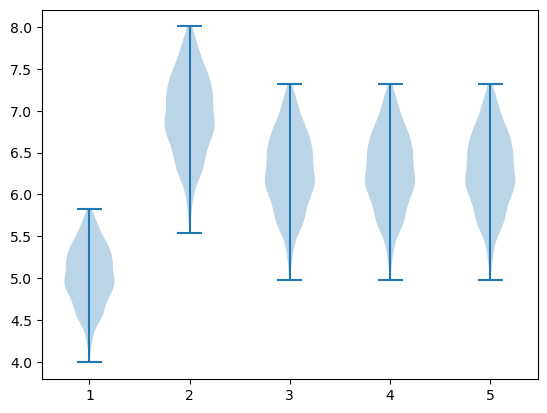

In [33]:
plt.violinplot([SNRs,SNRs_CE_het,SNRs_CE_ET,SNRs_CE_ET_NEMO,SNRs_CE_ET_NEMO_A1])

In [90]:
import bilby
import os
import logging

def create_ifo_from_asd_file(detector_name, asd_file_path):
    """
    Create an interferometer with PSD loaded from an ASD file.
    
    Parameters:
    -----------
    detector_name : str
        Name of the detector (e.g., 'H1', 'L1', 'CE1', 'NEMO')
    asd_file_path : str
        Path to the ASD file
        
    Returns:
    --------
    bilby.gw.detector.Interferometer
        Configured interferometer with PSD from file
        
    Raises:
    -------
    FileNotFoundError
        If the ASD file doesn't exist
    ValueError
        If detector name is invalid or ASD file format is incorrect
    RuntimeError
        If there's an issue creating the interferometer or loading PSD
    """
    
    # Validate inputs
    if not detector_name or not isinstance(detector_name, str):
        raise ValueError("detector_name must be a non-empty string")
    
    if not asd_file_path or not isinstance(asd_file_path, str):
        raise ValueError("asd_file_path must be a non-empty string")
    
    # Check if ASD file exists
    if not os.path.exists(asd_file_path):
        raise FileNotFoundError(f"ASD file not found: {asd_file_path}")
    
    # Check if file is readable
    if not os.access(asd_file_path, os.R_OK):
        raise PermissionError(f"Cannot read ASD file: {asd_file_path}")
    
    try:
        # Get PSD from ASD file
        psd = bilby.gw.detector.PowerSpectralDensity.from_amplitude_spectral_density_file(asd_file_path)
        
    except FileNotFoundError:
        raise FileNotFoundError(f"ASD file not found: {asd_file_path}")
    except ValueError as e:
        raise ValueError(f"Invalid ASD file format in {asd_file_path}: {str(e)}")
    except Exception as e:
        raise RuntimeError(f"Failed to load PSD from ASD file {asd_file_path}: {str(e)}")
    
    try:
        # Setup detector
        ifo = bilby.gw.detector.get_empty_interferometer(detector_name)
        
    except KeyError:
        raise ValueError(f"Unknown detector name: {detector_name}. "
                        f"Available detectors can be found using bilby.gw.detector.get_empty_interferometer.__doc__")
    except Exception as e:
        raise RuntimeError(f"Failed to create interferometer {detector_name}: {str(e)}")
    
    try:
        # Set the PSD
        ifo.power_spectral_density = psd
        
    except Exception as e:
        raise RuntimeError(f"Failed to set PSD for detector {detector_name}: {str(e)}")
    
    # Validate the result
    if ifo.power_spectral_density is None:
        raise RuntimeError(f"PSD was not properly set for detector {detector_name}")
    
    logging.info(f"Successfully created {detector_name} with PSD from {asd_file_path}")
    
    return ifo

In [101]:
# inject PMR but working with ifos instead of detector names
import numpy as np
import pandas as pd
import bilby
from concurrent.futures import ThreadPoolExecutor
import multiprocessing as mp

def inject_PMR_signal_vectorized_ifos(f_peaks, ifos, n_jobs=None):
    """
    Vectorized version to inject PMR signals for multiple frequencies
    
    Parameters:
    -----------
    f_peaks : array-like
        Array of frequencies in Hz
    network_conf : list
        Network configuration for interferometers
    n_jobs : int, optional
        Number of parallel jobs. If None, uses all available CPUs
    
    Returns:
    --------
    numpy.array : Array of network SNRs
    """
    f_peaks = np.array(f_peaks)
    
    # Set up parameters that don't change
    sampling_frequency = 16384
    duration = 1.0
    # Ra and dec - sky position is changed randomly
    np.random.seed(42) # This is a HACK FIX!!! we want the binaries to all be the same so we set a seed. 
    ra = np.random.uniform(0, 2 * np.pi)  # Right ascension: 0 to 2π
    dec = np.random.uniform(-np.pi/2, np.pi/2)  # Declination: -π/2 to π/2
    # Base injection parameters
    base_injection_parameters = dict(
        amplitude=5e-22,
        damping_time=0.2,
        phase=0,
        ra=ra,
        dec=dec,
        psi=0,
        t0=0.0,
        geocent_time=0.0,
    )
    
    # Set up waveform generator (assuming you have time_domain_damped_sinusoid defined)
    waveform_generator = bilby.gw.waveform_generator.WaveformGenerator(
        duration=duration,
        sampling_frequency=sampling_frequency,
        time_domain_source_model=time_domain_damped_sinusoid,
    )
    
    def calculate_snr_batch(f_peaks_batch):
        """Calculate SNR for a batch of frequencies"""
        network_snrs = []
        
        for f_peak in f_peaks_batch:
            # Update injection parameters
            injection_parameters = base_injection_parameters.copy()
            injection_parameters['frequency'] = f_peak
                    
            ifos.set_strain_data_from_power_spectral_densities(
                sampling_frequency=sampling_frequency,
                duration=duration,
                start_time=injection_parameters["geocent_time"] - 0.5,
            )
            
            # Inject signal
            ifos.inject_signal(
                waveform_generator=waveform_generator,
                parameters=injection_parameters,
                raise_error=False,
            )
            
            # Calculate network SNR
            network_snr_sqr = 0.0
            for ifo in ifos:
                if hasattr(ifo, 'meta_data') and 'optimal_SNR' in ifo.meta_data:
                    optimal_snr = ifo.meta_data['optimal_SNR']
                    network_snr_sqr += optimal_snr**2.0
            
            network_snr = np.sqrt(network_snr_sqr)
            network_snrs.append(network_snr)
        
        return network_snrs
    
    # Single-threaded for small datasets, parallel for large ones
    if len(f_peaks) < 100:
        network_snrs = calculate_snr_batch(f_peaks)
    else:
        # Parallel processing for large datasets
        if n_jobs is None:
            n_jobs = mp.cpu_count()
        
        # Split f_peaks into chunks
        chunk_size = max(1, len(f_peaks) // n_jobs)
        f_peaks_chunks = [f_peaks[i:i + chunk_size] for i in range(0, len(f_peaks), chunk_size)]
        
        # Process chunks in parallel
        with ThreadPoolExecutor(max_workers=n_jobs) as executor:
            chunk_results = list(executor.map(calculate_snr_batch, f_peaks_chunks))
        
        # Flatten results
        network_snrs = [snr for chunk_result in chunk_results for snr in chunk_result]
    
    return np.array(network_snrs)

def get_SNRs_from_ifos(PMR_samples, ifos):
    """
    Get SNRs from network configuration using vectorized injection
    
    Parameters:
    -----------
    PMR_samples : pandas.DataFrame
        DataFrame containing 'freq_khz' column with frequencies
    ifos : list
        List of interferometers
    
    Returns:
    --------
    numpy.array : Array of network SNRs
    """
    print(PMR_samples)
    
    # Convert freq_khz to Hz
    freq_hz = PMR_samples['freq_khz'] * 1000
    
    # Get SNRs using vectorized function
    SNRs = inject_PMR_signal_vectorized_ifos(freq_hz, ifos)
    
    return SNRs


In [100]:
# Onto the actual plots for the paper here
# Let us first construct our interferometers which we will use to make our violin plots
# We first want to construct a 20 km Cosmic explorer by reading in the strain data from a txt
# First setup a 
CE_20_asd_file = './detuned_asds/cosmic_explorer_20km_strain.txt'
CE_20_PMO_asd_file = './detuned_asds/cosmic_explorer_20km_strain.txt'
# Single detector
CE_20 = create_ifo_from_asd_file('CE',CE_20_asd_file)
print(CE)
# We then want to do the same for a 20 km Cosmic explorer that is PMO 
CE_20_PMO =create_ifo_from_asd_file('CE',CE_20_PMO_asd_file)
print(CE_20_PMO)

Interferometer(name='CE', power_spectral_density=PowerSpectralDensity(psd_file='None', asd_file='./detuned_asds/cosmic_explorer_20km_strain.txt'), minimum_frequency=10.0, maximum_frequency=2048.0, length=40.0, latitude=46.45514666666667, longitude=-119.4076571388889, elevation=142.554, xarm_azimuth=125.9994, yarm_azimuth=215.994, xarm_tilt=-0.0006195, yarm_tilt=1.25e-05)
Interferometer(name='CE', power_spectral_density=PowerSpectralDensity(psd_file='None', asd_file='./detuned_asds/cosmic_explorer_20km_strain.txt'), minimum_frequency=10.0, maximum_frequency=2048.0, length=40.0, latitude=46.45514666666667, longitude=-119.4076571388889, elevation=142.554, xarm_azimuth=125.9994, yarm_azimuth=215.994, xarm_tilt=-0.0006195, yarm_tilt=1.25e-05)


In [124]:
# Now inject our signals 
ifos = bilby.gw.detector.networks.InterferometerList([CE_20])
SNRs_CE_20 = get_SNRs_from_ifos(PMR_samples,ifos)
ifos = bilby.gw.detector.networks.InterferometerList([CE_20_PMO])
SNRs_CE_PMO = get_SNRs_from_ifos(PMR_samples,ifos)

       mass_solar  radius km  freq_khz  \
36503        2.48  16.792068  3.485029   
72194        2.88  17.403363  3.553949   
6213         2.53  15.166029  4.055441   
95553        2.42  16.519987  3.524832   
30919        2.77  16.974715  3.613604   
...           ...        ...       ...   
29981        2.74  16.895053  3.619016   
40952        2.54  17.450553  3.340724   
10538        2.33  15.793774  3.687134   
54206        2.70  15.769869  3.957794   
27592        2.47  17.435273  3.301942   

                                             source_file  
36503  /Users/smag0001/Downloads/f_peak_T_0_new/f_pea...  
72194  /Users/smag0001/Downloads/f_peak_T_0_new/f_pea...  
6213   /Users/smag0001/Downloads/f_peak_T_0_new/f_pea...  
95553  /Users/smag0001/Downloads/f_peak_T_0_new/f_pea...  
30919  /Users/smag0001/Downloads/f_peak_T_0_new/f_pea...  
...                                                  ...  
29981  /Users/smag0001/Downloads/f_peak_T_0_new/f_pea...  
40952  /Users/smag0001/

[3.52721078 3.46066478 3.09743385 ... 3.48168875 3.14201669 3.64238156]
[3.41198207 3.11712509 3.09743385 ... 3.16640733 3.89514025 3.72108198]
[0.96733149 0.90073015 1.         ... 0.90944583 1.23969432 1.02160686]


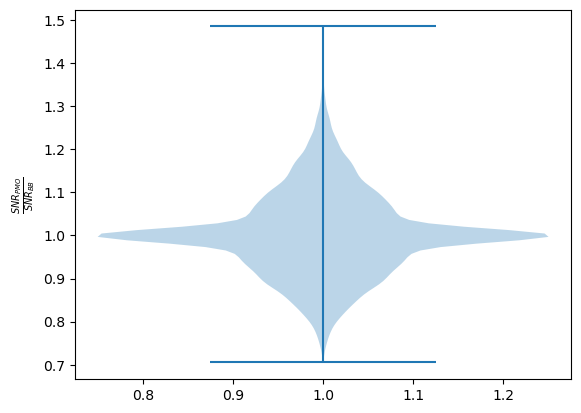

In [130]:
print(SNRs_CE_20)
print(SNRs_CE_PMO)
SNR_CE_20_norm = SNRs_CE_PMO/SNRs_CE_20
plt.violinplot(SNR_CE_20_norm)
plt.ylabel(r'$\frac{SNR_{PMO}}{SNR_{BB}}$')
print(SNR_CE_20_norm)

In [168]:
import pandas as pd
df =pd.read_csv('/Users/smag0001/Downloads/black_curve_data.csv')
print(df)

      frequency_Hz  strain_sensitivity_1_per_sqrtHz
0      1786.415091                     2.383816e-25
1      1797.320594                     2.398833e-25
2      1786.415091                     2.413944e-25
3      1786.415091                     2.429151e-25
4      1786.415091                     2.444454e-25
...            ...                              ...
1881   1808.292672                     2.413944e-25
1882   1808.292672                     2.398833e-25
1883   1819.331732                     2.383816e-25
1884   1808.292672                     2.383816e-25
1885   1797.320594                     2.383816e-25

[1886 rows x 2 columns]


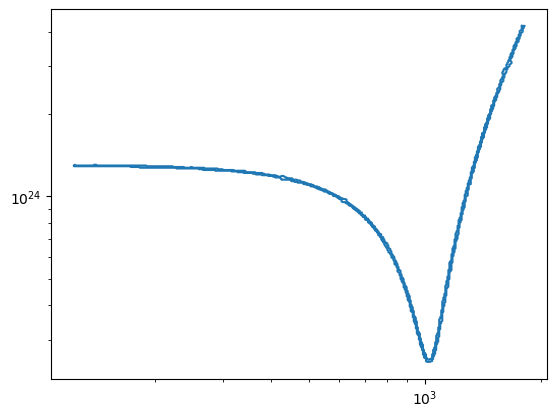

In [157]:
#plt.ylim(1e-25,1e-24)
plt.loglog(df['frequency_Hz'], 1/df['strain_sensitivity_1_per_sqrtHz'])

In [161]:
# --- General Correction: Invert Exponents ---
def invert_exponents(series):
    # Avoid divide-by-zero
    return np.where(series != 0, 1 / series, 0)

# Apply to column(s)
df['strain_sensitivity_1_per_sqrtHz'] = invert_exponents(df['strain_sensitivity_1_per_sqrtHz'])
print(df)

      frequency_Hz  strain_sensitivity_1_per_sqrtHz
0      1786.415091                     2.383816e-25
1      1797.320594                     2.398833e-25
2      1786.415091                     2.413944e-25
3      1786.415091                     2.429151e-25
4      1786.415091                     2.444454e-25
...            ...                              ...
1881   1808.292672                     2.413944e-25
1882   1808.292672                     2.398833e-25
1883   1819.331732                     2.383816e-25
1884   1808.292672                     2.383816e-25
1885   1797.320594                     2.383816e-25

[1886 rows x 2 columns]


In [175]:
#plt.ylim(1e-25,1e-24)
# --- Function to invert exponent manually ---
def invert_exponent(value):
    if value == 0:
        return 0  # Leave zeros unchanged
    mantissa, exponent = f"{value:.1e}".split('e')
    new_exponent = -int(exponent)
    return float(mantissa) * (10 ** new_exponent)
# Apply to column
# Vectorize for performance
# Apply to column(s)
# Apply to column(s)
df['strain_sensitivity_1_per_sqrtHz'] = invert_exponents(df['strain_sensitivity_1_per_sqrtHz'])
df['strain_sensitivity_1_per_sqrtHz'] = vectorized_invert(1./df['strain_sensitivity_1_per_sqrtHz'])

plt.loglog(df['frequency_Hz'], 1.df['strain_sensitivity_1_per_sqrtHz'])

SyntaxError: invalid decimal literal (1958103986.py, line 16)

In [171]:
df_sorted = df.sort_values(by='frequency_Hz')


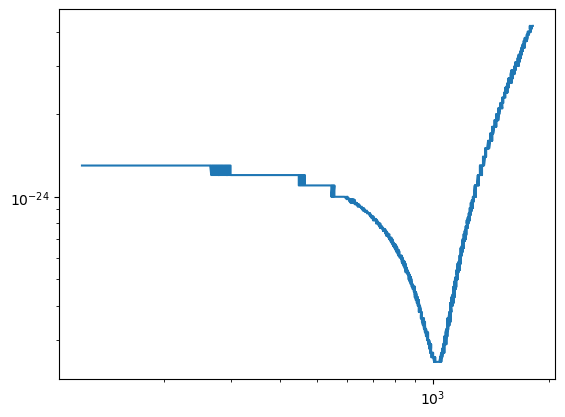

In [181]:
plt.loglog(df_sorted['frequency_Hz'], df_sorted['strain_sensitivity_1_per_sqrtHz']*1e-48)